# Creating a random forest classifier

## Aim: To classify breast cancer nuclei as 'benign' or 'malignant' using a random forest classifier

A random forest is a classification method that uses the outputs of multiple decision trees to make its predictions. While a decision tree classifier takes an 2D dataset as an input to train one decision tree, a random forest classifier takes a **bootstrapped** dataset to train a decision tree on a **subset** of features. The forest will be a combination of all the trees.

The random forest classifier will need to:
1. Bootstrap the data 
    * For a dataset with $n$ rows, a bootstrapped dataset will contain a random sample of those rows *with replacement*
    * For a random forest classifier containing $l$ trees, the dataset will be bootstrapped $l$ times to create $l$ different datasets containing $n$ rows. 
    
 
2. Select a subset of features
    * Each tree will be trained on a subset of the features, which will be randomly chosen *without replacement*
    * For a dataset containing $p$ features, there will be $ m \approx \sqrt{p}$ features in the subset
    * The resulting dataset will have dimension $(n, m, l)$ = (num. rows, num. subset features, num. bootstrapped datasets)
    
    
3. Train a decision tree for each bootstrapped dataset and subset of features
    * Use the scikit-learn DecisionTreeClassifier class to train each tree
    
    
4. Predict outputs for unseen data
    * Pass test data through each decision tree. The test dataset will not be bootstrapped, but will pass the same subset of features into the corresponding tree.
        - E.g. If tree 1 was trained on subset A of the training features, tree 1 will make predictions for subset A of the test features. 
    * The final 1D array of predictions for the test dataset will be the modal value across all the trees
    
    
This will be done by building a RandomForestClassifier class using an object oriented programming model.


### The dataset:

This notebook uses the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29), which labels tumours as malignant (M) or benign (B) according to 10 features describing the cell nucleus, e.g. its perimeter. Each feature has a mean, standard error and worst value, resulting in 30 features in total. 


In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn import tree
from scipy import stats
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

## Import data

In [2]:
data = pd.read_csv("data.csv", header=0)
labels = data[data.columns[1]]

In [3]:
# Replace labels B=0, M=1
binary_labels = labels.replace(to_replace='B', value=0)
binary_labels = binary_labels.replace(to_replace='M', value=1)

In [4]:
# Remove all columns that aren't features - expect 30 columns
data.pop('diagnosis')
del data['id']
del data['Unnamed: 32']
print(np.shape(data))

(569, 30)


## Obtain train and test labels and features

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, binary_labels, test_size=.2, random_state=41)

In [6]:
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")
Y_train = np.array(Y_train).reshape((np.shape(X_train)[0], 1))

No. of training examples: 455
No. of testing examples: 114


# Forest class

In [7]:
class RandomForestClassifier():
    
    def __init__(self, X, Y, num_bootstrap):
        '''Constructor'''
        
        # Combine features and labels so that corresponding labels get bootstrapped with the features
        self.data = np.concatenate((X, Y), axis=1)  
        
        self.num_bootstrap = num_bootstrap # number of bootstrapped datasets
        self.num_rows = np.shape(X)[0]     # number of data points
        self.num_features = np.shape(X)[1] # number of features
        self.num_columns = np.shape(self.data)[1] # concatenated number of columns (includes labels)
        self.num_sub_feats = int(np.sqrt(self.num_features))
        

    def bootstrap(self):
        '''
        Bootstraps rows from a dataset.
        Returns:
        big_boot - 3D array with dimensions (#data points x #columns x num_bootstrap)
        '''
        big_boot = np.zeros((self.num_rows, self.num_columns, self.num_bootstrap)) # 3D array of zeros

        for i in range(self.num_bootstrap):
            ind = np.random.choice(self.num_rows, size=self.num_rows, replace=True) # get n random incides with replacement
            big_boot[:,:,i] = self.data[ind,:]
        
        return big_boot
    
    def sub_feature(self):
        '''
        Extracts subset of features from original dataset 
    
        Returns:
        sub_feats: 3D array with no. columns = sqrt(num_features)
        ind: 2D array of indices of dimension (l,m) = (no. bootstrap x no. sub_feats)
        '''
        big_boot = self.bootstrap()[:,:-1,:] # exclude labels from feature pruning
    
        # Obtain 2D array of indices
        ind = np.zeros((self.num_bootstrap,self.num_sub_feats)) # empty array of indices
        for i in range(self.num_bootstrap):
            ind[i,:] = np.random.choice(self.num_features, size=self.num_sub_feats, replace=False)
        ind = ind.astype(int)
    
        # Obtain dataset containing subset of features
        sub_feats = np.zeros((self.num_rows, self.num_sub_feats, self.num_bootstrap)) # empty 3D array 
        for i in range(self.num_bootstrap):
            sub_feats[:,:,i] = big_boot[:,:,i][:,ind[i]]

        return sub_feats, ind
    
    def test_feats(self,test_data):
        '''
        Extracts the same sub_features from the test data as the training data to pass through each tree
        Returns:
        3D array with num_sub_feats columns with ith set of indices for the ith tree
        '''
        test_data = np.array(test_data) 
        num_test_rows = np.shape(test_data)[0]
        test_feats = np.zeros((num_test_rows,self.num_sub_feats,self.num_bootstrap)) # empty array of sub fetaures
        #sub_indices = self.sub_feature()[1] # dimension num. bootstrap x num. sub_features
        for i in range(self.num_bootstrap):
            test_feats[:,:,i] = test_data[:,self.sub_feature()[1][i,:]]
            
        return test_feats
        
    def predict(self, X_test,maxdepth,min_split,n_plot):
        '''Function to predict new data point(s) and plots n random trees.'''
        
        predictions = np.zeros((len(X_test),self.num_bootstrap)) # empty 2D array of predictions
        plot_indices = np.random.choice(self.num_bootstrap, n_plot, replace=False) # choose n_plot random trees to plot
        
        # Split sub-feature array into features and labels
        X_train, Y_train = self.sub_feature()[0], self.bootstrap()[:,-1,:]
        
        # Train num_bootstrap trees
        for i in range(self.num_bootstrap):
            classifier = tree.DecisionTreeClassifier(max_depth=maxdepth,min_samples_split=min_split) # redefine classifier for each tree
            classifier.fit(X_train[:,:,i],Y_train[:,i].reshape((self.num_rows,1))) # fit ith tree
            predictions[:,i]=classifier.predict(self.test_feats(X_test)[:,:,i])    # predict on test data
            for j in plot_indices:
                if i==j:
                    plt.figure(figsize=(15,15))
                    tree.plot_tree(classifier)
                    plt.show()
            
        mode = stats.mode(predictions, axis=1)[0] # modal value for each test datapoint across all trees
        return mode
        #return predictions

## Fit and predict

Create a forest containing 10 trees, with a maximum depth of 5 layers, and 3 minimum samples split.

Maximum depth: maximum number of layers a tree can have

Minimum samples split: minimum number of datapoints required before a node can split. 

3 of the trees will be chosen at random and plotted.

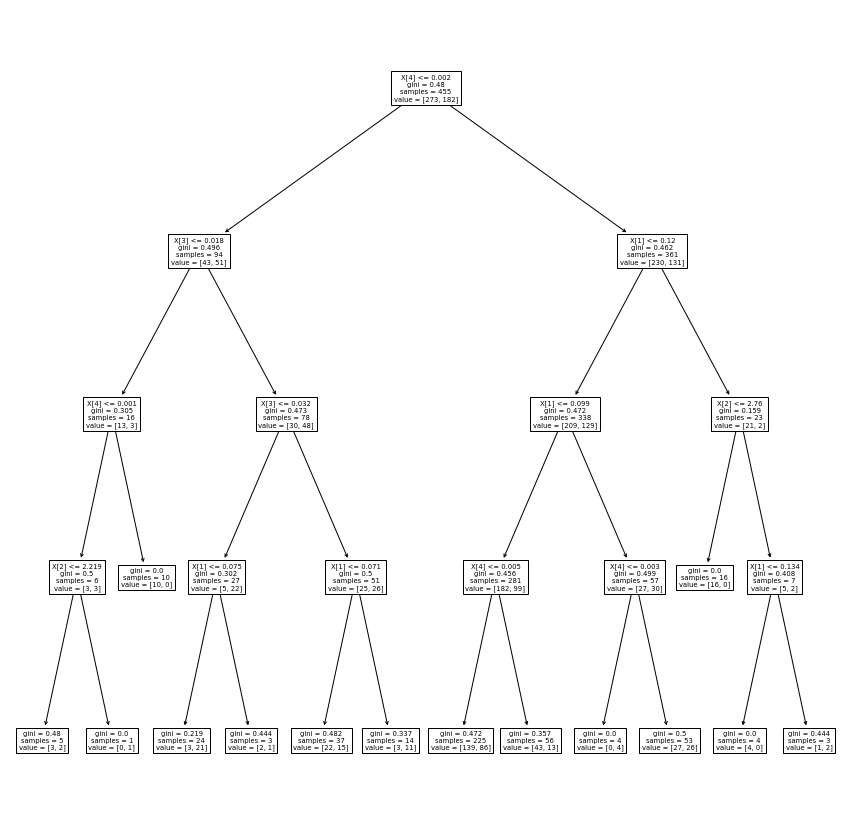

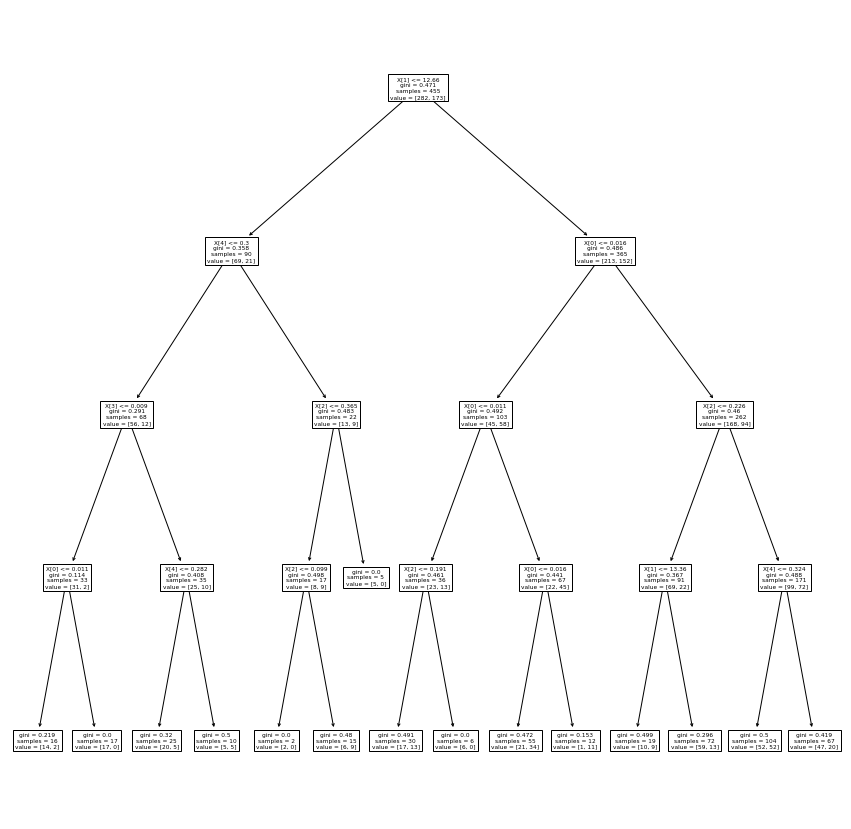

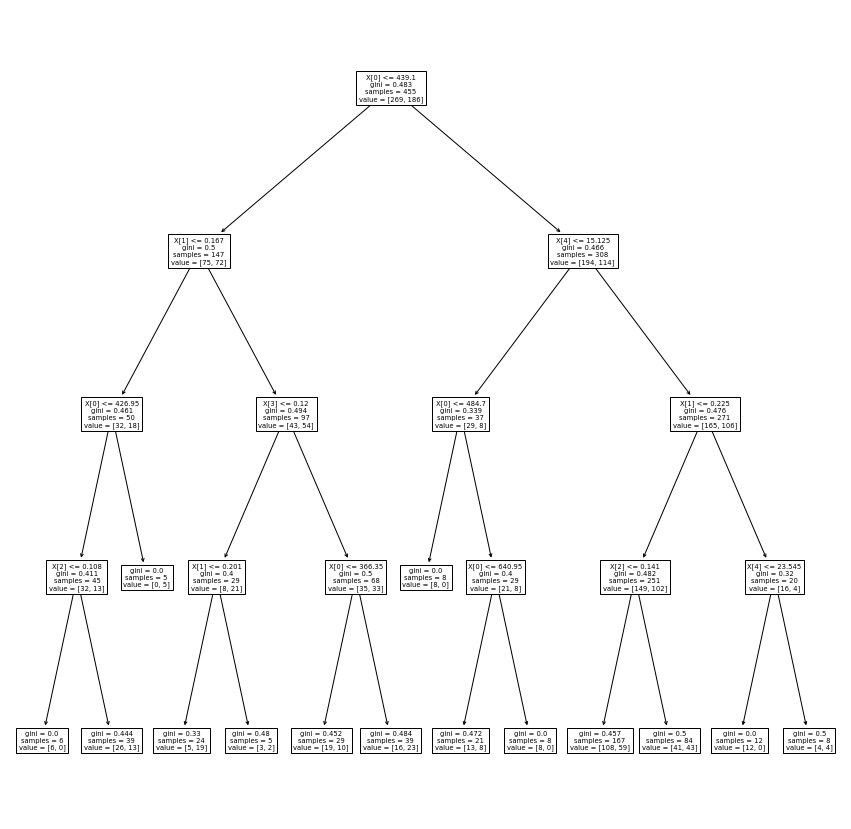

In [8]:
# Create tree for training dataset
forest = RandomForestClassifier(X_train,Y_train,num_bootstrap=10)

# Make predictions for test dataset
Y_pred = forest.predict(X_test,maxdepth=4,min_split=3,n_plot=3)

Most of the leaves (nodes without conditions, leading to a split) in the trees are impure, meaning they contain both benign and malignant data points. However most of the pure leaves are ones predicting benign tumours. It is possible that this is because the dataset is skewed, with an abundance of benign data points. This means any malignant datapoints are likely to be a minority in a leaf, making the tree less likely to classify malignant datapoints correctly. 

In [9]:
# Evaluate model
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.6491228070175439

# Discussion

A random forest classifier has been built by training decision trees on bootstrapped data and subsets of the features. The accuracy of this classifier is poor (65%), which can arise from multiple factors such as the forest structure or the dataset being skewed. Below is a list of these factors, and suggested investigations that can be made to improve the classifier.

- Node/feature importance: calculate node importance and try feature weighting. [Node/feature importance](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285) calculations assign a value to each node in the tree according to the importance of that node in the tree. The node importance can then be used to calculate feature importance.

- Feature subset: this notebook randomly selects the features for each subset. Add weights to features according to their importance, and select feature subsets from the weighted features.

- Error analysis: calculate precision, recall and F1 score to test if data is skewed. If yes, try undersampling biased class. 

- Criterion: this notebook uses the 'gini' factor to measure node impurity during tree training. Investigate the effect of the other measurements of impurity, such as entropy, on the forest performance.

- Forest infastructure: vary parameters describing the forest shape, e.g. maximum depth, number of trees, minimum samples split. Plot the classifier performance with respect to the varying parameter; is there a plateau? Is there a peak? What is the optimal configuration?

- Train the Scikit Learn RandomForestClassifier of the same forest structure on the same dataset. Compare the accuracy scores between the Scikit Learn and the above classifier, and understand any differences found in the code.

- Feature analysis: any correlations between features can be used to reduce the number of input variables, making the classifier less computationally expensive. For a dataset of this size, this may not be as important, but will become significant for larger datasets.